<a href="https://colab.research.google.com/github/meiqingli/dssj_summer2022/blob/main/DSSJ_Final_Project_Li.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Geographic Disparity in Publishing: A Sentiment Analysis from Subreddit Community**
**Meiqing Li | PhD Candidate in City and Regional Planning**

**DSSJ @ Berkeley**

In [3]:
# import packages
import pandas as pd
import numpy as np
import spacy
import re
import warnings
warnings.simplefilter("ignore")
from gensim.models.phrases import Phrases, Phraser

# load the English preprocessing pipeline
nlp = spacy.load("en_core_web_sm")

## Introduction
The subreddit of interest is [Publishing](https://www.reddit.com/r/publishing/), which is a community for publishing professionals to discuss various issues such as career and business opportunities. Through initial qualitative analysis, we found it a relatively small community compared with other subreddits by number of readers and posts. In terms of topics, we found discussions on different types of publishing, for example self-publishing,publishing through agent, and digital publishing, as well as publishing in the US vs. Canada. These are all potential areas for further investigation. 

Before cleaning up, our dataset includes 7,330 posts and 19,538 comments. By removing blank texts, we reduced the size of dataset to 2,388 posts and 19,054 comments. There have been a total of 1,922 unique users for posts, and 4,033 unique users for comments. Interestingly, we noticed that the most frequent user's posts take up 1% of the overall posts while the next only takes up 0.3%. Another observation we find interesting is that people are curious about the differences in publishing between US and Canada, whilst it seems that most of the posts are from people trying to navigate publishing but very little from the publisher side. For this project, I would like to look into the posts by different people involved in publishing, specifically the themes and sentiments within posts from different areas or regions. For example, how do the sentiments and concerns regarding publishing differ between US, Canada and other countries, or different parts of the US? Also, within each geographic region, what are the shares of posts by people interested in publishing, publishers, agents, and other stakeholders? I am interested in studying these dynamics because they can give us a better understanding about the broader landscape of publishing. 

In order to address these questions, I will look into several NLP techniques inlcuding *topic modeling* and *sentiment analysis*. Specifically, I will use tools such as *concordance* to identify texts with geographical key words, then extract topical words and sentiments. 

In [4]:
# Github url with post data
url_posts = 'https://gist.githubusercontent.com/meiqingli/2d128e1cac170d71b3820c51c6c3766e/raw/5be159378011713f1daaca4d683bb6875d11f61f/submissions.csv'

# Github url with comments data
url_comments = 'https://gist.githubusercontent.com/meiqingli/5d83de4c508a0564359b2dd07c6839b1/raw/a83a44b0a85ac8ccc10f717495ff6a85c2f93878/comments.csv'

# Reads the csv posts file from github
df_posts = pd.read_csv(url_posts)

# Reads the csv comments file from github
df_comments = pd.read_csv(url_comments)

In [5]:
# Tells us about the general shape of the dfs
df_posts.shape

(7330, 18)

In [6]:
df_comments.shape

(19538, 11)

In [7]:
# Allows us to see which columns our dfs have
list(df_posts)

['idint',
 'idstr',
 'created',
 'self',
 'nsfw',
 'author',
 'title',
 'url',
 'selftext',
 'score',
 'subreddit',
 'distinguish',
 'textlen',
 'num_comments',
 'flair_text',
 'flair_css_class',
 'augmented_at',
 'augmented_count']

In [8]:
list(df_comments)

['idint',
 'idstr',
 'created',
 'author',
 'parent',
 'submission',
 'body',
 'score',
 'subreddit',
 'distinguish',
 'textlen']

## Preprocessing
We mainly made the following preprocessing steps to the original dataset:

*   Drop redundant columns;
*   Remove rows in posts and comments that are either "removed" or "deleted";
*   Drop rows with null values in `selftext` and `body` columns;
*   Drop duplicate posts and columns;
*   Text cleaning using `spaCy`;
*   Phrase modeling with `gensim`;
*   Save preprocessed texts to new data frames for further analysis.

Code from this section is largely based on joint work by Madeline Bossi, Soliver Fusi, Janiya Peters, and me. 

In [9]:
# Drops less useful columns

df_posts_short = df_posts.drop(['subreddit', 'url', 'distinguish', 'flair_text', 'flair_css_class', 'augmented_at', 'augmented_count'], axis=1)
df_comments_short = df_comments.drop(['subreddit', 'distinguish'], axis=1)

In [10]:
# Selects all rows that don't have 'removed' or 'deleted' in certain columns
df_comments_noBlanks = df_comments_short.loc[~df_comments_short['body'].isin(['[removed]', '[deleted]' ]),:]
df_posts_noBlanks = df_posts_short.loc[~df_posts_short['selftext'].isin(['[removed]', '[deleted]' ]),:]

In [11]:
# Drops rows with null values in 'selftext' or 'body' column (assuming we want to analyze 'selftext')
df_posts_noBlanks = df_posts_noBlanks.dropna(subset=['selftext'])
df_comments_noBlanks = df_comments_noBlanks.dropna(subset=['body'])

In [12]:
# drop duplicate posts or comments
df_posts_noBlanks = df_posts_noBlanks.drop_duplicates(subset=['selftext'])
df_comments_noBlanks = df_comments_noBlanks.drop_duplicates(subset=['body'])

In [13]:
# Final number of posts
df_posts_noBlanks.shape

(2385, 11)

In [14]:
# Final number of comments
df_comments_noBlanks.shape

(18754, 9)

Our original dataset has 7,330 rows of posts and 19,538 rows of comments. After preprocessing, the dataset contains 2,385 posts and 18,754 comments, which are small subsets of the original ones. 

In [15]:
def clean(token):
    """Helper function that specifies whether a token is:
        - punctuation
        - space
        - digit
    """
    return token.is_punct or token.is_space or token.is_digit

def line_read(df, text_col='selftext'):
    """Generator function to read in text from df and get rid of line breaks."""    
    for text in df[text_col]:
        yield text.replace('\n', '')

def preprocess_posts(df, text_col='selftext', allowed_postags=['NOUN', 'ADJ']):
    """Preprocessing function to apply to the posts dataframe."""
    for parsed in nlp.pipe(line_read(df, text_col), batch_size=1000, disable=["ner"]):
        # Gather lowercased, lemmatized tokens
        tokens = [token.lemma_.lower() if token.lemma_ != '-PRON-'
                  else token.lower_ 
                  for token in parsed if not clean(token)]
        # Remove specific lemmatizations, and words that are not nouns or adjectives
        tokens = [lemma
                  for lemma in tokens
                  if not lemma in ["'s",  "’s", "’"] and not lemma in allowed_postags]
        # Remove stop words
        tokens = [token for token in tokens if token not in spacy.lang.en.stop_words.STOP_WORDS]
        yield tokens

# created a different preprocessing function for the comments df because the relevant column name is different
def preprocess_comments(df, text_col='body', allowed_postags=['NOUN', 'ADJ']):
    """Preprocessing function to apply to the comments dataframe."""
    for parsed in nlp.pipe(line_read(df, text_col), batch_size=1000, disable=["ner"]):
        # Gather lowercased, lemmatized tokens
        tokens = [token.lemma_.lower() if token.lemma_ != '-PRON-'
                  else token.lower_ 
                  for token in parsed if not clean(token)]
        # Remove specific lemmatizations, and words that are not nouns or adjectives
        tokens = [lemma
                  for lemma in tokens
                  if not lemma in ["'s",  "’s", "’"] and not lemma in allowed_postags]
        # Remove stop words
        tokens = [token for token in tokens if token not in spacy.lang.en.stop_words.STOP_WORDS]
        yield tokens


In [16]:
# creates a list of lists of lemmas in each post
lemmas_posts = [line for line in preprocess_posts(df_posts_noBlanks)]

# creates a list of lists of lemmas in each comment
lemmas_comments = [line for line in preprocess_comments(df_comments_noBlanks)]

In [17]:
# flattens the list of lists into one big list to facilitate counting lemma frequency
flat_lemmas_posts = [item for sublist in lemmas_posts for item in sublist]
# flat_lemmas_posts[:30]

In [18]:
# creates a df to see which lemmas are the most frequent
from collections import Counter
posts_count = Counter(flat_lemmas_posts)

lemma_freq_df_posts = pd.DataFrame.from_dict(posts_count, orient='index').reset_index()
lemma_freq_df_posts = lemma_freq_df_posts.rename(columns={'index':'lemma', 0:'count'})
lemma_freq_df_posts.sort_values('count', ascending=False)[:30]

,lemma,count
201,book,3134
187,publish,1794
2,publishing,1448
17,work,1393
3,like,1283
120,know,1130
188,want,1060
290,publisher,1059
174,write,971
77,look,836


In [19]:
# replicates this same process for the comments
flat_lemmas_comments = [item for sublist in lemmas_comments for item in sublist]
# flat_lemmas_comments[:30]

In [20]:
comments_count = Counter(flat_lemmas_comments)

lemma_freq_df_comments = pd.DataFrame.from_dict(comments_count, orient='index').reset_index()
lemma_freq_df_comments = lemma_freq_df_comments.rename(columns={'index':'lemma', 0:'count'})
lemma_freq_df_comments.sort_values('count', ascending=False)[:30]

,lemma,count
4,book,10150
72,work,5754
322,publisher,5155
6,publish,4775
25,publishing,4580
17,good,4248
161,like,4033
324,want,3643
170,author,3405
940,agent,3217


In [21]:
# Forming bigrams and trigrams

# Create bigram and trigram models for posts
bigram_posts = Phrases(lemmas_posts, min_count=10, threshold=100)
trigram_posts = Phrases(bigram_posts[lemmas_posts], min_count=10, threshold=50)  
bigram_phraser_posts = Phraser(bigram_posts)
trigram_phraser_posts = Phraser(trigram_posts)

# Form trigrams
trigrams_posts = [trigram_phraser_posts[bigram_phraser_posts[doc]] for doc in lemmas_posts]

# Create bigram and trigram models for comments
bigram_comments = Phrases(lemmas_comments, min_count=10, threshold=100)
trigram_comments = Phrases(bigram_comments[lemmas_comments], min_count=10, threshold=50)  
bigram_phraser_comments = Phraser(bigram_comments)
trigram_phraser_comments = Phraser(trigram_comments)

# Form trigrams
trigrams_comments = [trigram_phraser_comments[bigram_phraser_comments[doc]] for doc in lemmas_comments]

In [22]:
# joins each into a string
trigrams_joined_posts = [' '.join(trigram) for trigram in trigrams_posts]
trigrams_joined_posts[0]

'industry experience publishing like enter field specifically editing usual catch-22 hold true job need experience experience need job find entry_level work prove difficult live baltimore md feel exhaust obvious avenue send resume cover_letter magazine newspaper publishing house etc locate oppose internship course college student tend exclude consideration additionally support work pay obvious sense priority realize reader subreddit shot dark use advice person familiar industry consider send email editor blog read ask similar guidance perceive brazen'

In [23]:
# joins each into a string
trigrams_joined_comments = [' '.join(trigram) for trigram in trigrams_comments]
trigrams_joined_comments[0]

'great tip start market book online publish'

In [24]:
# adds lemmas column to submissions df (with option to make csv)
df_posts_noBlanks.insert(loc=7, column='lemmas', value=trigrams_joined_posts)
df_posts_noBlanks = df_posts_noBlanks[~df_posts_noBlanks['lemmas'].isin([''])]
df_posts_noBlanks.to_csv('submissions_lemmas.csv', index=False)

# adds lemmas column to comments df (with option to make csv)
df_comments_noBlanks.insert(loc=7, column='lemmas', value=trigrams_joined_comments)
df_comments_noBlanks = df_comments_noBlanks[~df_comments_noBlanks['lemmas'].isin([''])]
df_comments_noBlanks.to_csv('comments_lemmas.csv', index=False)

## Data Import

In [25]:
# Quickly import preprocessed datasets

# Github url with post data
url_posts_processed = 'https://gist.githubusercontent.com/meiqingli/7ce4c20c903c1befd574ed27750a0276/raw/bc80e78606664c73ed9cf583c00cc58bcd2e4af7/submissions_lemmas.csv'

# Github url with comments data
url_comments_processed = 'https://gist.githubusercontent.com/meiqingli/2fa6c4e3d3e08cc1c53ee88d7ee8e9ec/raw/dd3419bcb1b8dec10abc1f9a2fa6f45cbc93f511/comments_lemmas.csv'

# Reads the csv posts file from github
df_posts_processed = pd.read_csv(url_posts_processed)

# Reads the csv comments file from github
df_comments_processed = pd.read_csv(url_comments_processed)

## Analysis
For my analysis, I hope to distinguish between different people involved in publishing, as well as their geographic disparities. I will first extract posts/comments with geographic identifiers (e.g., countries, cities), then apply topic modeling and sentiment analysis to the subset. 

In [26]:
# First I will extract the posts and comments with geographic identifiers
# create a list of places of interest based on annotation
# narrow down to places of interest: UK, US, Canada, San Francisco (SF), Los Angeles (LA), New York (NYC), or Chicago
places = ['the US', 'Canada', 'UK', 'San Francisco', 'SF', 'NYC', 'Los Angeles', 'LA', 'New York', 'Chicago']
place = '|'.join(r"\b{}\b".format(x) for x in places)

posts = df_posts_processed[df_posts_processed['selftext'].str.contains(place)].reset_index()
comments = df_comments_processed[df_comments_processed['body'].str.contains(place)].reset_index()

In [27]:
len(posts)

170

In [28]:
posts.head(3)

,index,idint,idstr,created,self,nsfw,author,title,lemmas,selftext,score,textlen,num_comments
0,9,48792263,t3_t1scn,1335894315,1,0,B33sting,Looking to help my wife publish a book....need...,wife imho great writer school writing complete...,My wife is IMHO a great writer. She has gone t...,0,697,0
1,16,56061953,t3_xdloh,1343625086,1,0,castle_bravo,"/r/Publishing, I'm looking for advice on how t...",little bit graduate university having work cop...,A little bit about me: I graduated in May 2011...,4,1251,4
2,17,56393156,t3_xkp8k,1343930905,1,0,rusemean,How to find work in publishing? / Breaking int...,hi sorry wrong place post like partner try fin...,"Hi, there. I'm sorry if this is the wrong plac...",3,679,8


In [29]:
len(comments)

752

In [30]:
comments.head(3)

,index,idint,idstr,created,author,parent,submission,body,lemmas,score,textlen
0,5,26186955460,t1_c131c5g,1287706663,inigo_montoya,t1_c1317g0,t3_dtpk6,It's no mere degree. But you're fighting an up...,mere degree fight uphill_battle expect hard pu...,1,425
1,88,26462814228,t1_c5n9y50,1343941970,earwicker,t3_xkp8k,t3_xkp8k,I don't know if it's as relevant in the UK as ...,know relevant uk look mediabistro job listing ...,3,165
2,110,26494708926,t1_c669k8u,1347307627,[deleted],t3_zo380,t3_zo380,Xlibris provides a book publishing guide to wr...,xlibris provide book publishing guide writer a...,1,550


In [31]:
# create a subset of posts and comments
posts_us = df_posts_processed[df_posts_processed['selftext'].str.contains('the US')].reset_index()
comments_us = df_comments_processed[df_comments_processed['body'].str.contains('the US')].reset_index()

posts_uk = df_posts_processed[df_posts_processed['selftext'].str.contains('UK')].reset_index()
comments_uk = df_comments_processed[df_comments_processed['body'].str.contains('UK')].reset_index()

posts_canada = df_posts_processed[df_posts_processed['selftext'].str.contains('Canada')].reset_index()
comments_canada = df_comments_processed[df_comments_processed['body'].str.contains('Canada')].reset_index()

posts_sf = df_posts_processed[df_posts_processed['selftext'].str.contains('San Francisco | SF')].reset_index()
comments_sf = df_comments_processed[df_comments_processed['body'].str.contains('San Francisco | SF')].reset_index()

posts_la = df_posts_processed[df_posts_processed['selftext'].str.contains('Los Angeles | LA')].reset_index()
comments_la = df_comments_processed[df_comments_processed['body'].str.contains('Los Angeles | LA')].reset_index()

posts_ny = df_posts_processed[df_posts_processed['selftext'].str.contains('New York | NYC')].reset_index()
comments_ny = df_comments_processed[df_comments_processed['body'].str.contains('New York | NYC')].reset_index()

posts_chicago = df_posts_processed[df_posts_processed['selftext'].str.contains('Chicago')].reset_index()
comments_chicago = df_comments_processed[df_comments_processed['body'].str.contains('Chicago')].reset_index()

In [32]:
print(len(posts))
print(len(comments))

170
752


In [33]:
print('posts us:', len(posts_us))
print('comments us:', len(comments_us))

print('posts uk:',len(posts_uk))
print('comments uk:',len(comments_uk))

print('posts canada:',len(posts_canada))
print('comments canada:',len(comments_canada))

print('posts sf:',len(posts_sf))
print('comments sf:',len(comments_sf))

print('posts la:',len(posts_la))
print('comments la:',len(comments_la))

print('posts ny:',len(posts_ny))
print('comments ny:',len(comments_ny))

print('posts chicago:',len(posts_chicago))
print('comments chicago:',len(comments_chicago))

posts us: 44
comments us: 253
posts uk: 67
comments uk: 229
posts canada: 24
comments canada: 76
posts sf: 10
comments sf: 47
posts la: 6
comments la: 32
posts ny: 43
comments ny: 207
posts chicago: 9
comments chicago: 52


This is a subset of the original dataset. 

### Analysis 0: text analysis
Let's do some language analysis with `text()`.

In [34]:
tokens_posts = []
tokens_comments = []

for idx, row in enumerate(posts['lemmas']):
    # Notice that we put all tokens in the same list
    tokens_posts.extend(row.split(' '))

for idx, row in enumerate(comments['lemmas']):
    # Notice that we put all tokens in the same list
    tokens_comments.extend(row.split(' '))

In [35]:
import nltk
nltk.download('stopwords')
from nltk.text import Text

publish_tokens_posts = Text(tokens_posts)
publish_tokens_comments = Text(tokens_comments)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Concordances

In [36]:
# examine text and occurance of places
publish_tokens_posts.concordance('uk', width=75)

Displaying 25 of 87 matches:
business particular city nottingham uk particularly keen proofreading unpa
know impossible canada know publish uk hear need agent true good way hi fo
 master publishing child literature uk ireland recommend good programs?my 
lar focus good source job ideal job uk graduate study grad program good tr
dvice hello guy 1st year ba student uk apply american macmillan publishing
cape publishing capacity especially uk usa having return publishing confer
ook award literary gathering attend uk actually speaker work amazon hear s
 harpercollins transworld doubleday uk branch exciting world self publishi
e recommendation possible ma course uk u.s. probably impossible financial 
charge isbn generation distribution uk respectively allow profit isbn stip
ness medium outlet etc idea company uk print colour page a4 art book price
n appeal people age target_audience uk ireland book know start basic quest
e europe post want highlight london uk base book publisher look future 

In [37]:
publish_tokens_comments.collocation_list()

[('publishing', 'house'),
 ('self', 'publish'),
 ('los', 'angeles'),
 ('good', 'way'),
 ('lot', 'people'),
 ('traditional', 'publishing'),
 ('picture', 'book'),
 ('live', 'nyc'),
 ('self', 'publishing'),
 ('literary', 'agent'),
 ('sound', 'like'),
 ('hope', 'help'),
 ('let', 'know'),
 ('feel', 'free'),
 ('job', 'board'),
 ('west', 'coast'),
 ('book', 'expo'),
 ('good', 'seller'),
 ('star', 'wars'),
 ('interior', 'design')]

### Analysis 1: qualitative analysis - word cloud

In [38]:
# add word cloud here
# ! pip install wordcloud
from wordcloud import WordCloud

In [39]:
text_posts = posts.lemmas.str.cat(sep=', ')
text_comments = comments.lemmas.str.cat(sep=', ')

text_comments_us = comments_us.lemmas.str.cat(sep=', ')
text_comments_uk = comments_uk.lemmas.str.cat(sep=', ')
text_comments_canada = comments_canada.lemmas.str.cat(sep=', ')

In [40]:
wordcloud_posts = WordCloud().generate(text_posts)
wordcloud_comments = WordCloud().generate(text_comments)

wordcloud_comments_us = WordCloud().generate(text_comments_us)
wordcloud_comments_uk = WordCloud().generate(text_comments_uk)
wordcloud_comments_canada = WordCloud().generate(text_comments_canada)

(-0.5, 399.5, 199.5, -0.5)

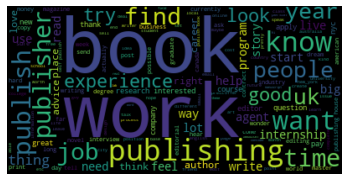

In [41]:
import matplotlib.pyplot as plt

plt.imshow(wordcloud_posts, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

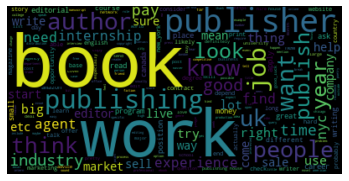

In [42]:
plt.imshow(wordcloud_comments, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

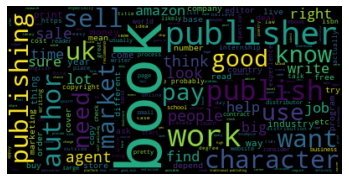

In [43]:
# examine keywords/topic difference across countries
plt.imshow(wordcloud_comments_us, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

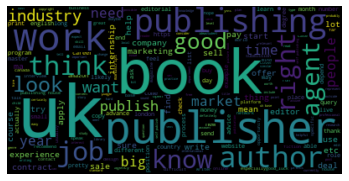

In [44]:
plt.imshow(wordcloud_comments_uk, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

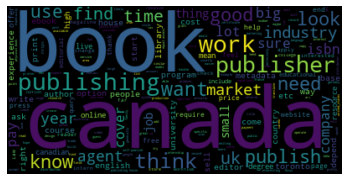

In [45]:
plt.imshow(wordcloud_comments_canada, interpolation='bilinear')
plt.axis("off")

### Analysis 2: topic analysis - LDA model

In [46]:
# create TF-IDF matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize, using only the top 5000 TF-IDF values
vectorizer = TfidfVectorizer(max_df=0.85,
                                   min_df=0.01, #to ignore the zeros
                                   decode_error='ignore',
                                   stop_words='english',
                                   smooth_idf=True,
                                   use_idf=True)

X_comments_us = comments_us['lemmas']
X_comments_uk = comments_uk['lemmas']
X_comments_canada = comments_canada['lemmas']

tfidf_comments_us =  vectorizer.fit_transform(X_comments_us)
tfidf_comments_uk =  vectorizer.fit_transform(X_comments_uk)
tfidf_comments_canada =  vectorizer.fit_transform(X_comments_canada)

In [47]:
# apply LDA model to posts and comments (this takes a while)
from sklearn.decomposition import LatentDirichletAllocation

In [48]:
# function to plot the words for each topic:
def plot_top_words(model, feature_names, n_top_words=10, n_row=1, n_col=3, normalize=False):
    """Plot the top words for an LDA model.
    
    Parameters
    ----------
    model : LatentDirichletAllocation object
        The trained LDA model.
    feature_names : list
        A list of strings containing the feature names.
    n_top_words : int
        The number of top words to show for each topic.
    n_row : int
        The number of rows to use in the subplots.
    n_col : int
        The number of columns to use in the subplots.
    normalize : bool
        If True, normalizes the topic model weights.
    """
    fig, axes = plt.subplots(n_row, n_col, figsize=(3 * n_col, 5 * n_row), sharex=True)
    axes = axes.flatten()
    components = model.components_
    if normalize:
        components = components / components.sum(axis=1)[:, np.newaxis]

    for topic_idx, topic in enumerate(components):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)

        for i in "top right left".split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)

    return fig, axes

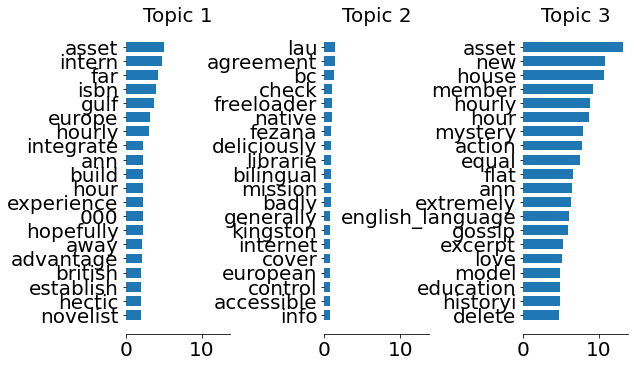

In [49]:
# plot US topics
lda = LatentDirichletAllocation(n_components=3, max_iter=20, random_state=0)
lda_comments_us = lda.fit(tfidf_comments_us)

token_names = vectorizer.get_feature_names_out()
plot_top_words(lda_comments_us, token_names,20, 1, 3)
plt.show()

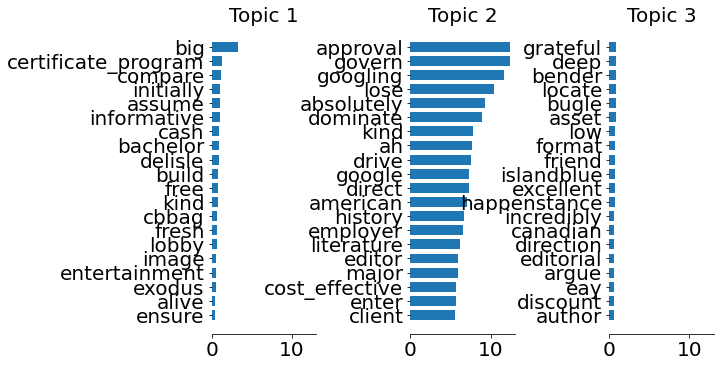

In [50]:
# plot UK topics
lda = LatentDirichletAllocation(n_components=3, max_iter=20, random_state=0)
lda_comments_uk = lda.fit(tfidf_comments_uk)

token_names = vectorizer.get_feature_names_out()
plot_top_words(lda_comments_uk, token_names,20, 1, 3)
plt.show()

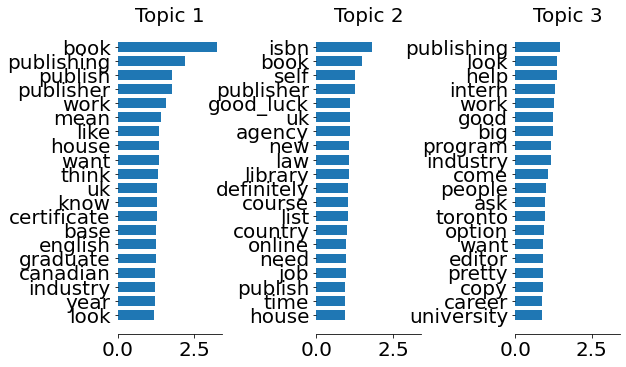

In [51]:
# plot Canada topics
lda = LatentDirichletAllocation(n_components=3, max_iter=20, random_state=0)
lda_comments_canada = lda.fit(tfidf_comments_canada)

token_names = vectorizer.get_feature_names_out()
plot_top_words(lda_comments_canada, token_names,20, 1, 3)
plt.show()

### Analysis 3: sentiment analysis



In [52]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 3.3 MB/s 


In [53]:
analyzer = SentimentIntensityAnalyzer()

In [54]:
# sentences_posts = posts['selftext'].tolist()
sentences_comments_la = comments_la['body'].tolist()
sentences_comments_sf = comments_sf['body'].tolist()
sentences_comments_chicago = comments_chicago['body'].tolist()
sentences_comments_ny = comments_ny['body'].tolist()

In [55]:
# la scores
cols = ['sentence', 'score']
la_score = []
for sentence in sentences_comments_la:
    vs = analyzer.polarity_scores(sentence)
    la_score.append({'sentence': sentence, 'score': str(vs)})
    #print("{:-<65} {}".format(sentence, str(vs)))
df_score_la = pd.DataFrame(la_score, columns=cols)
# splitting
df_score_la[['0', '1', '2', '3', '4']] = df_score_la.score.str.split(":",expand=True)
df_score_la = df_score_la.drop(['0', '1', '2', '3'], axis=1)
df_score_la[['compound', '4']] = df_score_la['4'].str.split("}",expand=True)
df_score_la = df_score_la.drop(['4'], axis=1)
df_score_la.head()

,sentence,score,compound
0,"1. Do you live in New York, Chicago, or LA?","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0
1,Los Angeles public relations & social media ma...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0
2,It is illegal in the U.S. to discriminate pote...,"{'neg': 0.139, 'neu': 0.801, 'pos': 0.06, 'com...",-0.5473
3,It's considered by some to be a high status jo...,"{'neg': 0.029, 'neu': 0.89, 'pos': 0.081, 'com...",0.8692
4,"My rates are below, and they are flexible base...","{'neg': 0.014, 'neu': 0.961, 'pos': 0.025, 'co...",0.2263


In [56]:
# sf scores
cols = ['sentence', 'score']
sf_score = []
for sentence in sentences_comments_sf:
    vs = analyzer.polarity_scores(sentence)
    sf_score.append({'sentence': sentence, 'score': str(vs)})
    #print("{:-<65} {}".format(sentence, str(vs)))
df_score_sf = pd.DataFrame(sf_score, columns=cols)
# splitting
df_score_sf[['0', '1', '2', '3', '4']] = df_score_sf.score.str.split(":",expand=True)
df_score_sf = df_score_sf.drop(['0', '1', '2', '3'], axis=1)
df_score_sf[['compound', '4']] = df_score_sf['4'].str.split("}",expand=True)
df_score_sf = df_score_sf.drop(['4'], axis=1)
df_score_sf.head()

,sentence,score,compound
0,It's no mere degree. But you're fighting an up...,"{'neg': 0.145, 'neu': 0.768, 'pos': 0.087, 'co...",-0.5267
1,Search for markets on http://thegrinder.diabol...,"{'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'comp...",0.9392
2,"Publishing is SUPER hard to break into, especi...","{'neg': 0.019, 'neu': 0.835, 'pos': 0.146, 'co...",0.9757
3,"I'm a San Francisco resident, and much of my f...","{'neg': 0.02, 'neu': 0.859, 'pos': 0.122, 'com...",0.9336
4,In my opinion it is less about the main charac...,"{'neg': 0.017, 'neu': 0.925, 'pos': 0.058, 'co...",0.6439


In [57]:
# ny scores
cols = ['sentence', 'score']
ny_score = []
for sentence in sentences_comments_ny:
    vs = analyzer.polarity_scores(sentence)
    ny_score.append({'sentence': sentence, 'score': str(vs)})
    #print("{:-<65} {}".format(sentence, str(vs)))
df_score_ny = pd.DataFrame(ny_score, columns=cols)
# splitting
df_score_ny[['0', '1', '2', '3', '4']] = df_score_ny.score.str.split(":",expand=True)
df_score_ny = df_score_ny.drop(['0', '1', '2', '3'], axis=1)
df_score_ny[['compound', '4']] = df_score_ny['4'].str.split("}",expand=True)
df_score_ny = df_score_ny.drop(['4'], axis=1)
df_score_ny.head()

,sentence,score,compound
0,I can only speak for publishing in NYC. In the...,"{'neg': 0.011, 'neu': 0.896, 'pos': 0.093, 'co...",0.9273
1,"I'm in the NYC area, which is the right place ...","{'neg': 0.038, 'neu': 0.829, 'pos': 0.133, 'co...",0.8338
2,Throwaway account. I am in the production depa...,"{'neg': 0.093, 'neu': 0.83, 'pos': 0.077, 'com...",-0.2382
3,It's definitely hard lately but good luck!\n\n...,"{'neg': 0.015, 'neu': 0.718, 'pos': 0.267, 'co...",0.9696
4,"Quercus, the British publishing house that gai...","{'neg': 0.0, 'neu': 0.871, 'pos': 0.129, 'comp...",0.8074


In [58]:
# chicago scores
cols = ['sentence', 'score']
chicago_score = []
for sentence in sentences_comments_chicago:
    vs = analyzer.polarity_scores(sentence)
    chicago_score.append({'sentence': sentence, 'score': str(vs)})
    #print("{:-<65} {}".format(sentence, str(vs)))
df_score_chicago = pd.DataFrame(chicago_score, columns=cols)
# splitting
df_score_chicago[['0', '1', '2', '3', '4']] = df_score_chicago.score.str.split(":",expand=True)
df_score_chicago = df_score_chicago.drop(['0', '1', '2', '3'], axis=1)
df_score_chicago[['compound', '4']] = df_score_chicago['4'].str.split("}",expand=True)
df_score_chicago = df_score_chicago.drop(['4'], axis=1)
df_score_chicago.head()

,sentence,score,compound
0,Does Philadelphia have anything like Portland'...,"{'neg': 0.0, 'neu': 0.836, 'pos': 0.164, 'comp...",0.802
1,Have you tried searching on [Media Bistro](htt...,"{'neg': 0.0, 'neu': 0.914, 'pos': 0.086, 'comp...",0.8391
2,"I love this! While we use Chicago, I do miss M...","{'neg': 0.098, 'neu': 0.61, 'pos': 0.292, 'com...",0.6351
3,Assistantships for publishing are few and far ...,"{'neg': 0.025, 'neu': 0.862, 'pos': 0.112, 'co...",0.9541
4,"Eh, maybe. Did you take any editing classes at...","{'neg': 0.017, 'neu': 0.85, 'pos': 0.133, 'com...",0.9978


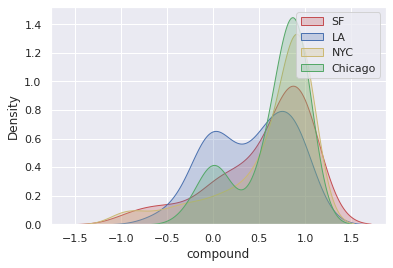

In [59]:
# plot density of the sentiment scores
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set_theme(style="darkgrid")
 
# plotting distibutions on the same figure
fig = sns.kdeplot(df_score_sf['compound'].astype(float), shade=True, color="r")
fig = sns.kdeplot(df_score_la['compound'].astype(float), shade=True, color="b")
fig = sns.kdeplot(df_score_ny['compound'].astype(float), shade=True, color="y")
fig = sns.kdeplot(df_score_chicago['compound'].astype(float), shade=True, color="g")
plt.legend(labels=["SF","LA", "NYC", "Chicago"])
plt.show()

## Analysis 4: non-Western context and language detection

Since Reddit is an English community, the hypothesis is that its contents are inherently biased towards Western contexts. In the next section, I will explore to what extent 'publishing' in non-Western contexts are discussed in the subreddit, and in what capacity. I will identify posts/comments that contain selected non-Western countries, then compare them with those in Western contexts. Additionally, I will apply the `Language Detection` model to identify non-English posts/comments. 

In [60]:
# add some non-Western countries to the dictionary: 
places_2 = ['China', 'Japan', 'Mexico', 'Russia', 'Asia', 'Africa']
place_2 = '|'.join(r"\b{}\b".format(x) for x in places)

posts_2 = df_posts_processed[df_posts_processed['selftext'].str.contains(place_2)].reset_index()
comments_2 = df_comments_processed[df_comments_processed['body'].str.contains(place_2)].reset_index()

In [61]:
print(len(posts_2))
print(len(comments_2))

170
752


In [62]:
# create a subset of posts and comments
posts_China = df_posts_processed[df_posts_processed['selftext'].str.contains('China')].reset_index()
comments_China = df_comments_processed[df_comments_processed['body'].str.contains('China')].reset_index()

posts_uk = df_posts_processed[df_posts_processed['selftext'].str.contains('UK')].reset_index()
comments_uk = df_comments_processed[df_comments_processed['body'].str.contains('UK')].reset_index()

posts_canada = df_posts_processed[df_posts_processed['selftext'].str.contains('Canada')].reset_index()
comments_canada = df_comments_processed[df_comments_processed['body'].str.contains('Canada')].reset_index()

posts_sf = df_posts_processed[df_posts_processed['selftext'].str.contains('San Francisco | SF')].reset_index()
comments_sf = df_comments_processed[df_comments_processed['body'].str.contains('San Francisco | SF')].reset_index()

posts_la = df_posts_processed[df_posts_processed['selftext'].str.contains('Los Angeles | LA')].reset_index()
comments_la = df_comments_processed[df_comments_processed['body'].str.contains('Los Angeles | LA')].reset_index()

posts_ny = df_posts_processed[df_posts_processed['selftext'].str.contains('New York | NYC')].reset_index()
comments_ny = df_comments_processed[df_comments_processed['body'].str.contains('New York | NYC')].reset_index()

In [63]:
# compare distribution and sentiments of posts and comments from two main datasets: Western places and non-Western places


### Language Detection model

In [64]:
# import dataset
url_language_dataset = 'https://gist.githubusercontent.com/meiqingli/9bbe8815197185b1b382c878a4797e87/raw/24e4c92a0444d08caa9bc79057288dabf05cde34/Language%2520Detection.csv'
data_language = pd.read_csv(url_language_dataset)

In [69]:
x = data_language["Text"]
y = data_language["Language"]

In [70]:
# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [72]:
# text preprocessing
data_list = []
for text in x:
  text = re.sub(r'[!@#$(),n"%^*?:;~`0-9]', ' ', text)
  text = re.sub(r'[[]]', ' ', text)
  text = text.lower()
  data_list.append(text)

In [73]:
# bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(data_list).toarray()
X.shape

(10337, 34937)

In [81]:
# train test splitting
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [82]:
# model training and prediction
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [83]:
y_pred = model.predict(x_test)

In [84]:
# model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
ac = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy is:", ac)

Accuracy is: 0.9748549323017408


In [ ]:
# deploy the model on reddit dataset




```
Conclude the analysis:

How did this analysis address your research question?
Reflect on any new or unexpected patterns, consider further exploratory analysis into those patterns.
Identify any limitations of the analysis and how they may impact the results.
And then on to the next analysis/question.
```



It has already been found that a very small percentage of Reddit’s users create the vast majority of the site’s content, so we would not be surprised if only a few users could influence the discourse of entire subreddits. Identifying these users would help us understand how a subreddit's discourse is shaped. 

In [ ]:
df = df.sort_values(by='score', ascending=False)[:1000]
# Sanity check
print(df.shape)

In [ ]:
df.author.nunique()

In [ ]:
df.plot('score', 'num_comments', kind='scatter', color='black', alpha=0.25, logy=True)

In [ ]:
# bigger theme of social justice
# ideas for dictionary: the us, states of the US

In [ ]:
## Rank by geographic areas, map distribution
## Word embedding and topic modeling
## Cluster Analysis
## Sentiment analysis
## Network analysis

## Conclusion

```
This section is a brief summary of your analyses and final thoughts:

What was your conclusions in response to your research questions?
What are potential implications of these results to the broader community?
Reflect on how this project relates the the themes of the workshop.
How would you further develop this research project?
```

## Next Steps

*   `entity organizer` from `spaCy`

In [ ]:
# list of countries
# language in additional to Western countries

Feedback: Really enjoyed your presentation yesterday. One thing you could do that addresses one of the questions you got is to examine the prevalence of tokens from non-Western countries. To what degree are people asking questions about publishing in these countries? It will likely be much less, since Reddit tends to be dominated by folks from Western countries.

Social justice question: access to publishing


## References
*   Getting Started with Sentiment Analysis using Python. (n.d.). Retrieved July 17, 2022, from https://huggingface.co/blog/sentiment-analysis-python
*   King, G., Pan, J., & Roberts, M. E. (2013). How Censorship in China Allows Government Criticism but Silences Collective Expression. American Political Science Review, 107(2), 326–343. https://doi.org/10.1017/S0003055413000014
*   Lucy, L., Demszky, D., Bromley, P., & Jurafsky, D. (2020). Content Analysis of Textbooks via Natural Language Processing: Findings on Gender, Race, and Ethnicity in Texas U.S. History Textbooks. AERA Open, 6(3), 233285842094031. https://doi.org/10.1177/2332858420940312



**Tools:**
*   [Sentiment analysis](https://github.com/cjhutto/vaderSentiment)
*   [Getting started with sentiment analysis](https://huggingface.co/blog/sentiment-analysis-python)